In [26]:
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import shutil
import torch
import glob
import os


EPOCH = 40
SEED = 7777
DROPOUT = 0.5
BATCH_SIZE = 32
THRESHOLD = 0.3
NUM_WORKERS = 4
LEARNING_RATE = 0.0025
GAMMA = 0.95
IMAGE_SIZE = (256, 256)
P1, P2, P3, P4, P5, P6 = [True] * 6
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


class ImageTransform():
    def __init__(self, mean, std):
        self.data_transforms = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std)
        ])
    
    def __call__(self, img):
        return self.data_transforms(img)


class TransparentDataset(Dataset):
    def __init__(self, img_path, mask_path, transform = None):
        super(TransparentDataset, self).__init__()
        self.img_list = img_path
        self.mask_list = mask_path
        self.transform = transform

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx])
        img = self.transform(img)
        
        mask_img = Image.open(self.mask_list[idx]).resize(IMAGE_SIZE).getchannel("R")
        mask_img = to_tensor(mask_img)
        mask_img = (mask_img >= THRESHOLD).float().reshape(1, *IMAGE_SIZE)
        
        return img, mask_img

def unzip(filename, extract_dir, archive_format):
    shutil.unpack_archive(filename, extract_dir, archive_format)

def get_dir_str(dir_name):
    return (os.path.join(dir_name, 'images/*'), os.path.join(dir_name, 'masks/*'))

def calc_conf_metrics_value(pred, y):
    result = {
        "tp" : torch.logical_and(pred >= THRESHOLD, y==1.).sum().item(),
        "tn" : torch.logical_and(pred < THRESHOLD, y==0.).sum().item(),
        "fp" : torch.logical_and(pred >= THRESHOLD, y==0.).sum().item(),
        "fn" : torch.logical_and(pred < THRESHOLD, y==1.).sum().item()
    }

    return result

def save_conf_metrics(values: list, total:int, file_name: str):
    score = np.array(values) / total
    plt.matshow(score, cmap = plt.get_cmap('Greys'))
    
    for i in range(len(score)):
        for j in range(len(score[i])):
            plt.text(j, i, "{:.4f}".format(score[i][j]), ha = 'center', va = 'center', color = 'red')
    
    plt.xticks(np.arange(len(score)), ["True", "False"])
    plt.yticks(np.arange(len(score)), ["True", "False"])
    
    plt.ylabel("Predictions")
    plt.xlabel("Ground Truth")
    
    plt.colorbar(shrink = 0.8, aspect = 10)
    plt.clim(0., 1.0)
    plt.savefig('confusion matrics/' + file_name)
    
def get_F1(tp, fp, fn, epsilon=1e-10):
    precision = tp/(tp + fp + epsilon)
    recall = tp/(tp + fn + epsilon)
    return 2 * precision * recall / (precision + recall + epsilon)

def get_ROC_point(tp, fp, tn, fn, epsilon=1e-10):
    sensitivity = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    return (1-specificity, sensitivity)
    
def save_line_graph(x, y, title, file_name, color, marker='o', ylim=None):
    fig = plt.figure()
    fig.set_facecolor('white')
    plt.plot(x, y, color=color, marker=marker)
    if ylim is not None :
        plt.ylim(ylim[0], ylim[1])
    
    plt.title(title)
    plt.savefig(file_name)

def extract_number(filename):
    return int(re.search(r'\d+', filename).group())

In [27]:
# 1. Data Preparation
if P1:
    train_images_dir, train_masks_dir = get_dir_str('./train')
    valid_images_dir, valid_masks_dir = get_dir_str('./validation')
    test_images_dir, test_masks_dir = get_dir_str('./test')
    
    train_images, train_masks, \
    valid_images, valid_masks, \
    test_images, test_masks = \
    [sorted(glob.glob(_), key=extract_number) for _ in [train_images_dir, train_masks_dir,
                                                     valid_images_dir, valid_masks_dir,
                                                     test_images_dir, test_masks_dir]]
    
    for _ in [train_images, train_masks, valid_images, valid_masks, test_images, test_masks]:
        print(len(_), _[:11:2], sep="\n", end="\n\n")
    

470
['./train/images/3.jpg', './train/images/9.jpg', './train/images/14.jpg', './train/images/16.jpg', './train/images/21.jpg', './train/images/23.jpg']

470
['./train/masks/3_mask.png', './train/masks/9_mask.png', './train/masks/14_mask.png', './train/masks/16_mask.png', './train/masks/21_mask.png', './train/masks/23_mask.png']

65
['./validation/images/19.jpg', './validation/images/67.jpg', './validation/images/87.jpg', './validation/images/110.jpg', './validation/images/140.jpg', './validation/images/149.jpg']

65
['./validation/masks/19_mask.png', './validation/masks/67_mask.png', './validation/masks/87_mask.png', './validation/masks/110_mask.png', './validation/masks/140_mask.png', './validation/masks/149_mask.png']

86
['./test/images/1.jpg', './test/images/4.jpg', './test/images/6.jpg', './test/images/11.jpg', './test/images/13.jpg', './test/images/20.jpg']

86
['./test/masks/1_mask.png', './test/masks/4_mask.png', './test/masks/6_mask.png', './test/masks/11_mask.png', './test/m

In [28]:
# 2. Data Preprocessing
if P2:
    transform = ImageTransform(
        mean = (0., 0., 0.),
        std = (0.5, 0.5, 0.5)
    )

    train_set = TransparentDataset(
        img_path = train_images,
        mask_path = train_masks,
        transform = transform
    )

    valid_set = TransparentDataset(
        img_path = valid_images,
        mask_path = valid_masks,
        transform = transform
    )

    train_loader = DataLoader(
        train_set,
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        prefetch_factor = NUM_WORKERS
    )

    valid_loader = DataLoader(
        valid_set,
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        prefetch_factor = NUM_WORKERS
    )


In [29]:
# 3. Define Model Architecture
if P3:
    class ConvLayer(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(ConvLayer, self).__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels,
                                   kernel_size = 3, padding = 1,
                                   padding_mode = 'circular', bias = True)
            self.bn1 = nn.BatchNorm2d(out_channels)
            
            self.conv2 = nn.Conv2d(out_channels, out_channels,
                                   kernel_size = 3, padding = 1,
                                   padding_mode = 'circular', bias = True)
            self.bn2 = nn.BatchNorm2d(out_channels)
            
            self.relu = nn.ReLU(inplace = True)
            self.dropout = nn.Dropout(p = DROPOUT)
            
            # He Initialization
            init.kaiming_normal_(self.conv1.weight, mode = 'fan_out', nonlinearity = 'relu')
            init.kaiming_normal_(self.conv2.weight, mode = 'fan_out', nonlinearity = 'relu')

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.dropout(x)
            return x

    class EncoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(EncoderBlock, self).__init__()
            self.conv_layer = ConvLayer(in_channels, out_channels)
            self.pool = nn.MaxPool2d(kernel_size = (2, 2))

        def forward(self, x):
            feature = self.conv_layer(x)
            output = self.pool(feature)
            return feature, output

    class DecoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(DecoderBlock, self).__init__()
            self.up = nn.ConvTranspose2d(in_channels, out_channels,
                                         kernel_size = (2, 2), stride = 2, bias = True)
            self.conv_layer = ConvLayer(in_channels, out_channels)

        def forward(self, x, feature):
            x = self.up(x)
            x = torch.cat((x, feature), dim=1)
            x = self.conv_layer(x)
            return x

    class UNet(nn.Module):
        def __init__(self):
            super(UNet, self).__init__()

            self.e1 = EncoderBlock(3, 32)
            self.e2 = EncoderBlock(32, 64)
            self.e3 = EncoderBlock(64, 128)
            self.e4 = EncoderBlock(128, 256)

            self.b = ConvLayer(256, 512)

            self.d1 = DecoderBlock(512, 256)
            self.d2 = DecoderBlock(256, 128)
            self.d3 = DecoderBlock(128, 64)
            self.d4 = DecoderBlock(64, 32)

            self.conv = nn.Conv2d(32, 1, kernel_size = (1, 1),
                                  padding_mode = 'circular', bias = True)
            init.kaiming_normal_(self.conv.weight, mode = 'fan_out', nonlinearity = 'relu')

        def forward(self, x):
            f1, x = self.e1(x)
            f2, x = self.e2(x)
            f3, x = self.e3(x)
            f4, x = self.e4(x)

            x = self.b(x)

            x = self.d1(x, f4)
            x = self.d2(x, f3)
            x = self.d3(x, f2)
            x = self.d4(x, f1)

            x = self.conv(x)
            return x

    Training: 100%|██████████| 15/15 [04:06<00:00, 12.61s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.86s/it]
                                                             

tp>:278, fp<:1031, tn>:3495715, fn<:762816
loss: tensor(1.6392)
f1 score: 0.000727
fpr, tpr: 0.000295, 0.000364


    Training: 100%|██████████| 15/15 [04:02<00:00, 12.40s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.76s/it]
                                                             

tp>:1280, fp<:9006, tn>:3487740, fn<:761814
loss: tensor(0.4666)
f1 score: 0.003310
fpr, tpr: 0.002576, 0.001677


    Training: 100%|██████████| 15/15 [03:59<00:00, 12.22s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.90s/it]
                                                             

tp>:32409, fp<:80637, tn>:3416109, fn<:730685
loss: tensor(0.4571)
f1 score: 0.073981
fpr, tpr: 0.023061, 0.042471


    Training: 100%|██████████| 15/15 [04:04<00:00, 12.61s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  6.19s/it]
                                                             

tp>:427906, fp<:1316403, tn>:2180343, fn<:335188
loss: tensor(0.4774)
f1 score: 0.341314
fpr, tpr: 0.376465, 0.560751


    Training: 100%|██████████| 15/15 [04:00<00:00, 12.32s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.72s/it]
                                                             

tp>:265671, fp<:639945, tn>:2856801, fn<:497423
loss: tensor(0.4564)
f1 score: 0.318415
fpr, tpr: 0.183012, 0.348150


    Training: 100%|██████████| 15/15 [04:04<00:00, 12.75s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:26<00:00,  6.38s/it]
                                                             

tp>:552800, fp<:1387104, tn>:2109642, fn<:210294
loss: tensor(0.4714)
f1 score: 0.409027
fpr, tpr: 0.396684, 0.724419


    Training: 100%|██████████| 15/15 [04:06<00:00, 12.53s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  6.16s/it]
                                                             

tp>:387843, fp<:727953, tn>:2768793, fn<:375251
loss: tensor(0.4204)
f1 score: 0.412843
fpr, tpr: 0.208180, 0.508251


    Training: 100%|██████████| 15/15 [04:10<00:00, 13.04s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.89s/it]
                                                             

tp>:232653, fp<:422976, tn>:3073770, fn<:530441
loss: tensor(0.4334)
f1 score: 0.327975
fpr, tpr: 0.120963, 0.304881


    Training: 100%|██████████| 15/15 [04:12<00:00, 13.10s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  6.04s/it]
                                                             

tp>:623666, fp<:2427251, tn>:1069495, fn<:139428
loss: tensor(0.5197)
f1 score: 0.327039
fpr, tpr: 0.694146, 0.817286


    Training: 100%|██████████| 15/15 [04:13<00:00, 13.16s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.88s/it]
                                                             

tp>:601365, fp<:2388912, tn>:1107834, fn<:161729
loss: tensor(0.5190)
f1 score: 0.320440
fpr, tpr: 0.683181, 0.788061


    Training: 100%|██████████| 15/15 [04:13<00:00, 12.98s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  5.98s/it]
                                                             

tp>:401882, fp<:663621, tn>:2833125, fn<:361212
loss: tensor(0.4127)
f1 score: 0.439552
fpr, tpr: 0.189782, 0.526648


    Training: 100%|██████████| 15/15 [04:15<00:00, 13.18s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  6.17s/it]
                                                             

tp>:133210, fp<:219909, tn>:3276837, fn<:629884
loss: tensor(0.4348)
f1 score: 0.238682
fpr, tpr: 0.062890, 0.174566


    Training: 100%|██████████| 15/15 [04:10<00:00, 13.02s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  6.03s/it]
                                                             

tp>:53288, fp<:152158, tn>:3344588, fn<:709806
loss: tensor(0.4807)
f1 score: 0.110038
fpr, tpr: 0.043514, 0.069832


    Training: 100%|██████████| 15/15 [04:06<00:00, 12.88s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.92s/it]
                                                             

tp>:629508, fp<:1273968, tn>:2222778, fn<:133586
loss: tensor(0.4511)
f1 score: 0.472148
fpr, tpr: 0.364330, 0.824942


    Training: 100%|██████████| 15/15 [04:09<00:00, 12.90s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  6.03s/it]
                                                             

tp>:192653, fp<:187427, tn>:3309319, fn<:570441
loss: tensor(0.3979)
f1 score: 0.337049
fpr, tpr: 0.053600, 0.252463


    Training: 100%|██████████| 15/15 [04:11<00:00, 13.16s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.86s/it]
                                                             

tp>:259664, fp<:283917, tn>:3212829, fn<:503430
loss: tensor(0.4154)
f1 score: 0.397442
fpr, tpr: 0.081195, 0.340278


    Training: 100%|██████████| 15/15 [04:11<00:00, 13.13s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  6.16s/it]
                                                             

tp>:285832, fp<:286505, tn>:3210241, fn<:477262
loss: tensor(0.4030)
f1 score: 0.428075
fpr, tpr: 0.081935, 0.374570


    Training: 100%|██████████| 15/15 [04:13<00:00, 13.11s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:25<00:00,  6.04s/it]
                                                             

tp>:192122, fp<:180971, tn>:3315775, fn<:570972
loss: tensor(0.4258)
f1 score: 0.338187
fpr, tpr: 0.051754, 0.251767


    Training: 100%|██████████| 15/15 [04:05<00:00, 12.50s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.85s/it]
                                                             

tp>:149209, fp<:124011, tn>:3372735, fn<:613885
loss: tensor(0.4154)
f1 score: 0.287961
fpr, tpr: 0.035465, 0.195532


    Training: 100%|██████████| 15/15 [04:02<00:00, 12.34s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.81s/it]
                                                             

tp>:15875, fp<:19456, tn>:3477290, fn<:747219
loss: tensor(0.4323)
f1 score: 0.039766
fpr, tpr: 0.005564, 0.020803


    Training: 100%|██████████| 15/15 [03:58<00:00, 12.25s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.74s/it]
                                                             

tp>:62246, fp<:57508, tn>:3439238, fn<:700848
loss: tensor(0.4180)
f1 score: 0.141012
fpr, tpr: 0.016446, 0.081571


    Training: 100%|██████████| 15/15 [03:58<00:00, 12.23s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.87s/it]
                                                             

tp>:15378, fp<:12274, tn>:3484472, fn<:747716
loss: tensor(0.4386)
f1 score: 0.038895
fpr, tpr: 0.003510, 0.020152


    Training: 100%|██████████| 15/15 [03:59<00:00, 12.40s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.78s/it]
                                                             

tp>:35084, fp<:39864, tn>:3456882, fn<:728010
loss: tensor(0.4273)
f1 score: 0.083729
fpr, tpr: 0.011400, 0.045976


    Training: 100%|██████████| 15/15 [03:57<00:00, 12.17s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.92s/it]
                                                             

tp>:105361, fp<:80428, tn>:3416318, fn<:657733
loss: tensor(0.4118)
f1 score: 0.222074
fpr, tpr: 0.023001, 0.138071


    Training: 100%|██████████| 15/15 [03:58<00:00, 12.18s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.75s/it]
                                                             

tp>:81279, fp<:65967, tn>:3430779, fn<:681815
loss: tensor(0.4151)
f1 score: 0.178568
fpr, tpr: 0.018865, 0.106512


    Training: 100%|██████████| 15/15 [04:00<00:00, 12.51s/it]
                                                             
    Validation: 100%|██████████| 3/3 [00:24<00:00,  5.88s/it]
                                                             

tp>:9615, fp<:13877, tn>:3482869, fn<:753479
loss: tensor(0.4490)
f1 score: 0.024447
fpr, tpr: 0.003969, 0.012600


Done.


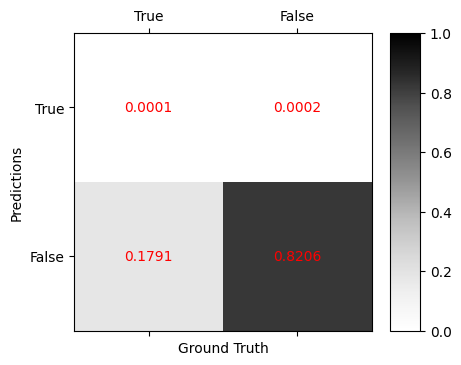

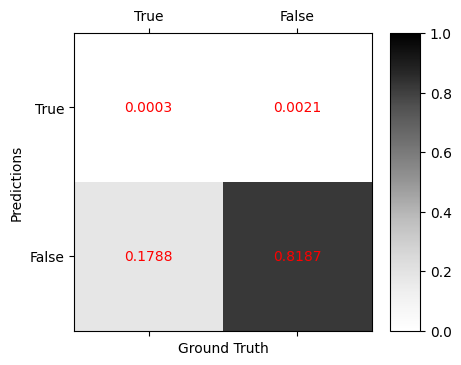

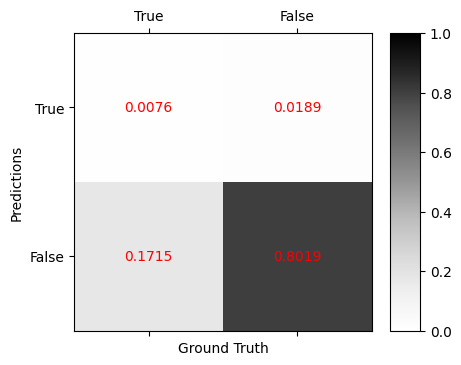

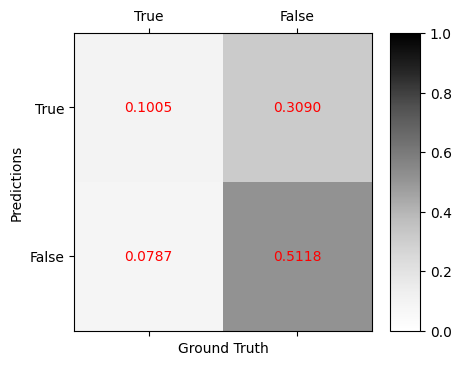

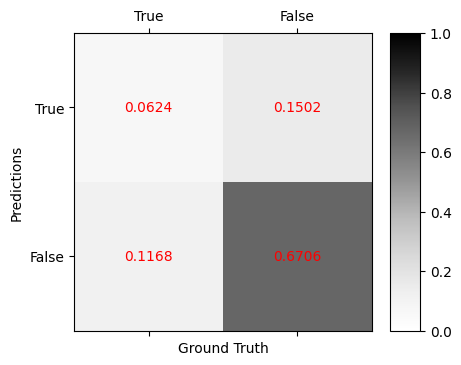

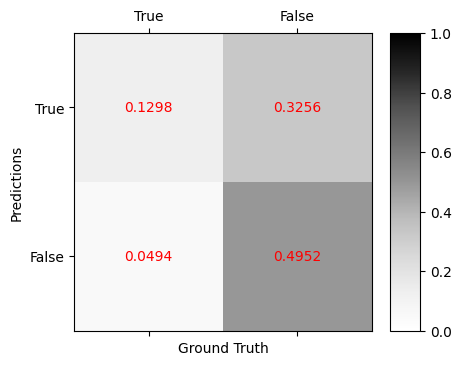

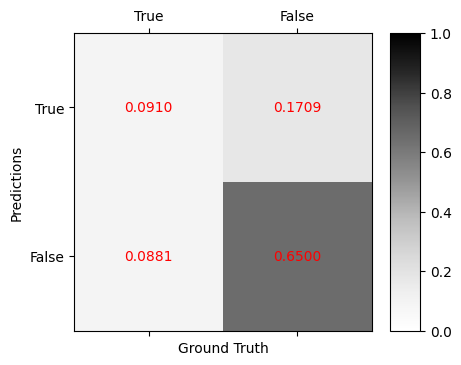

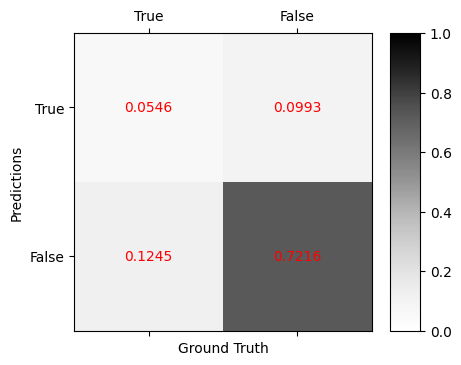

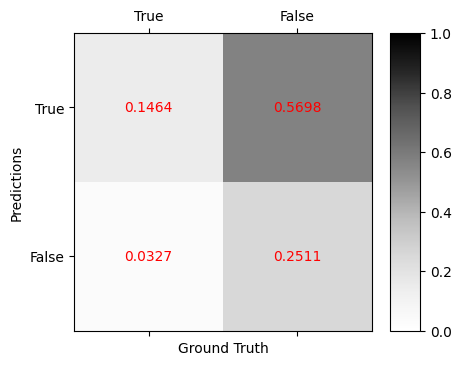

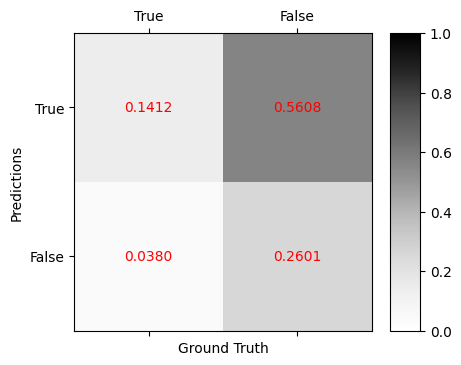

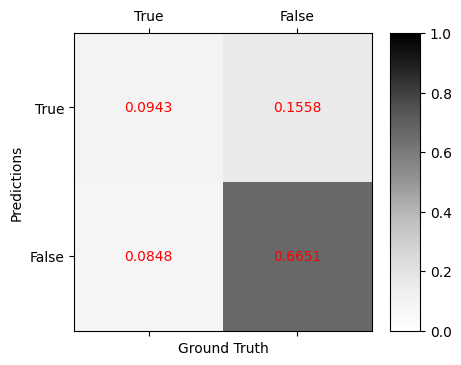

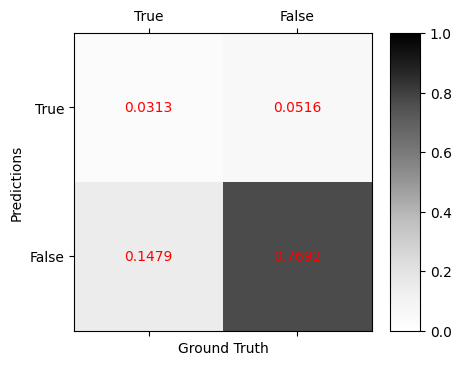

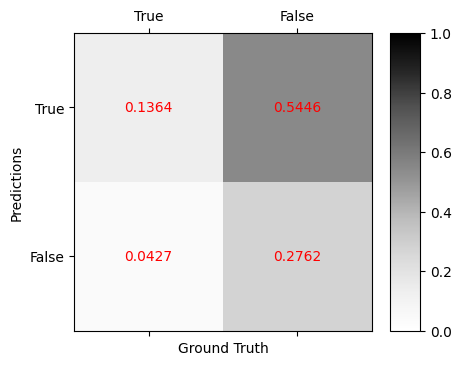

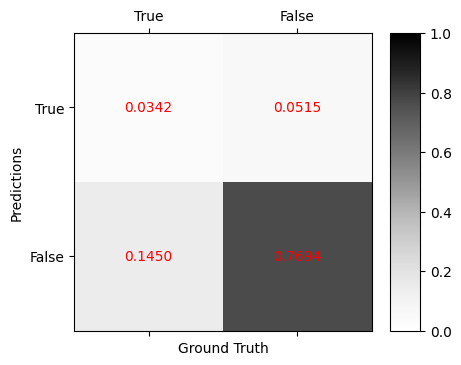

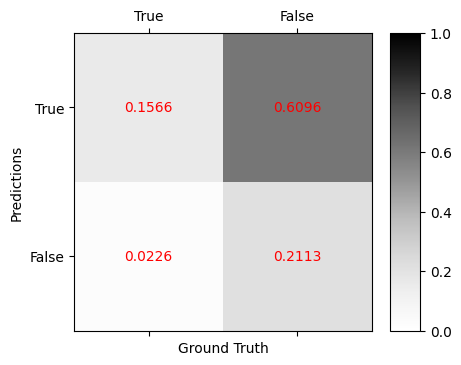

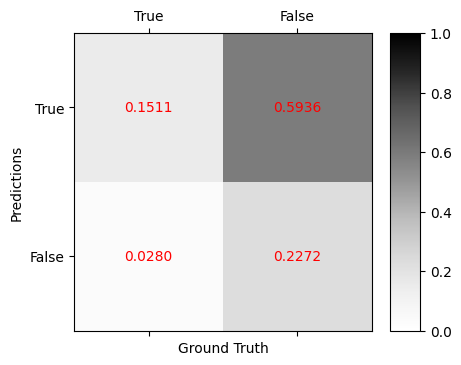

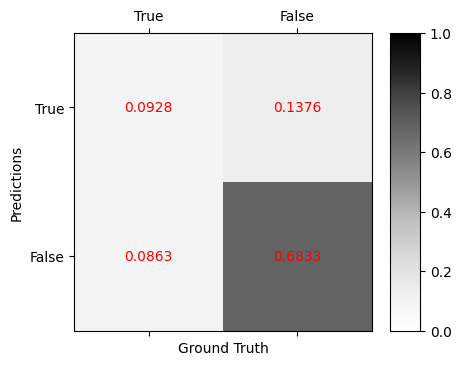

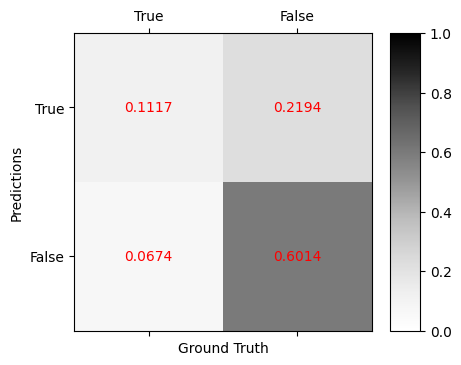

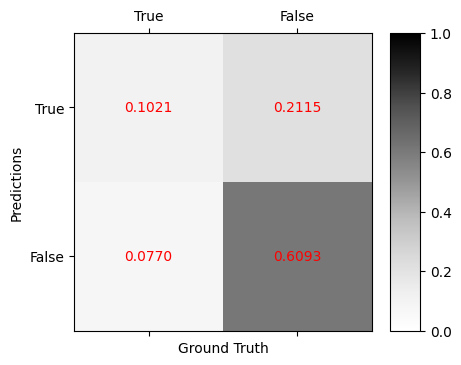

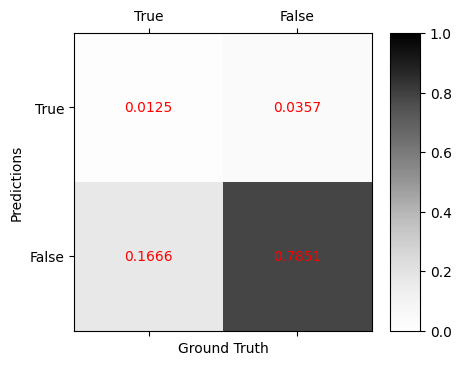

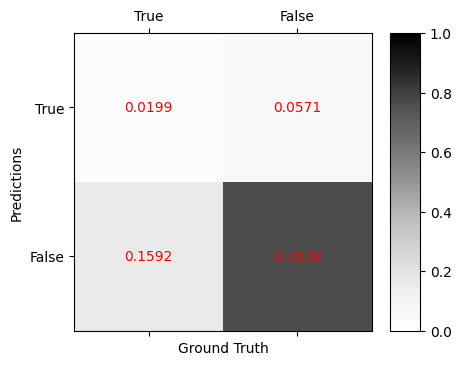

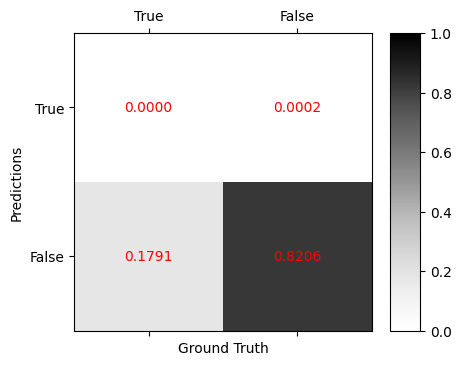

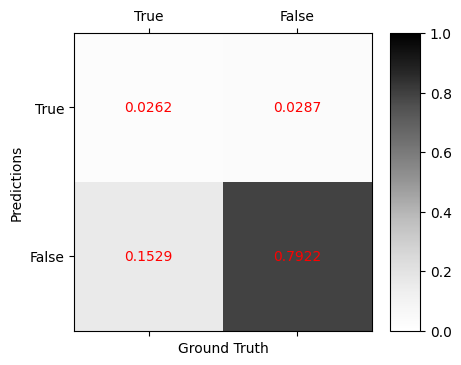

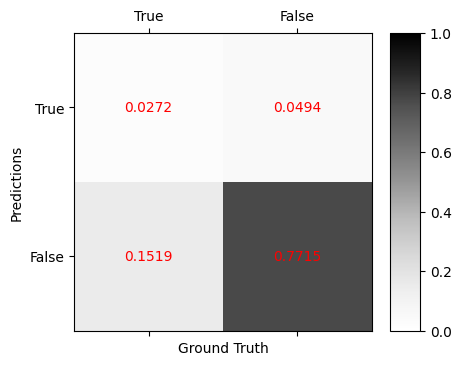

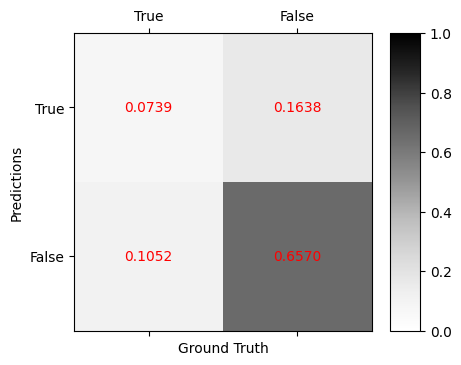

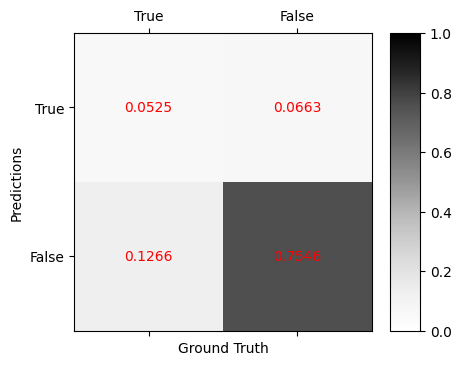

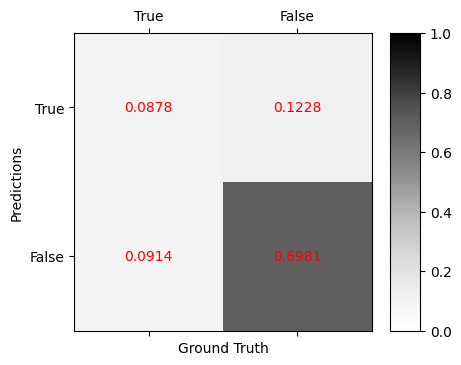

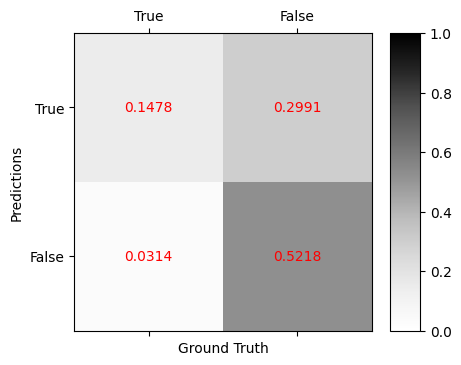

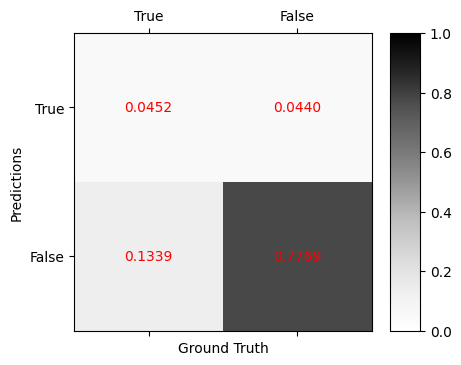

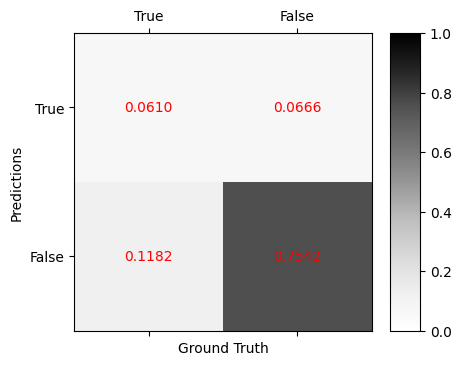

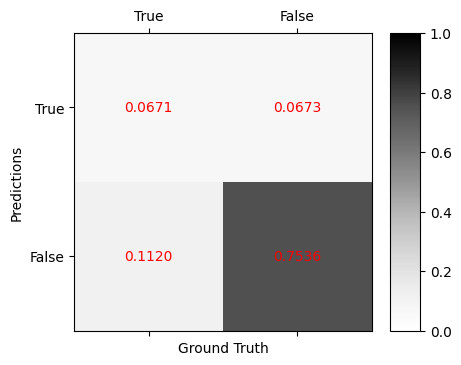

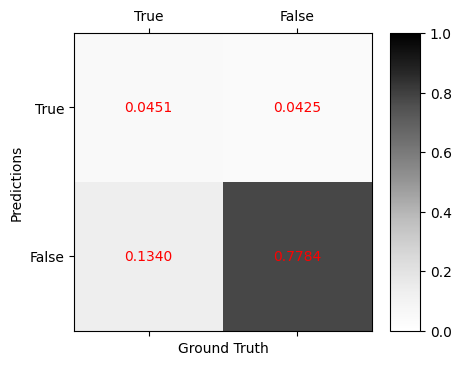

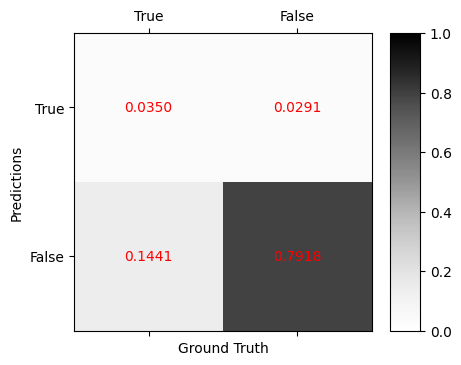

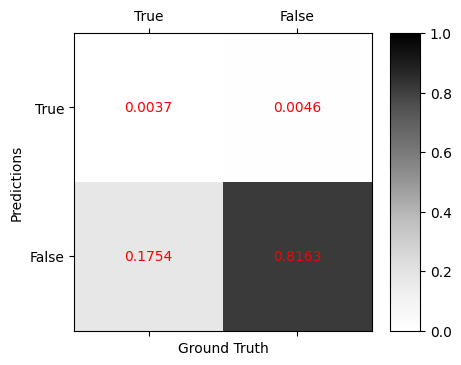

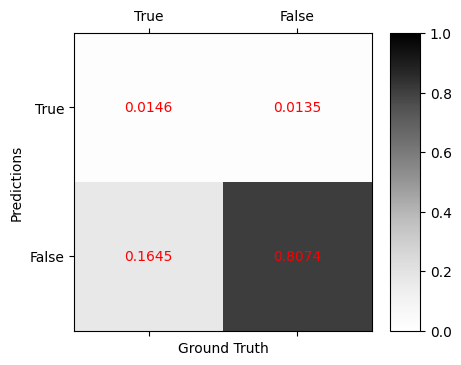

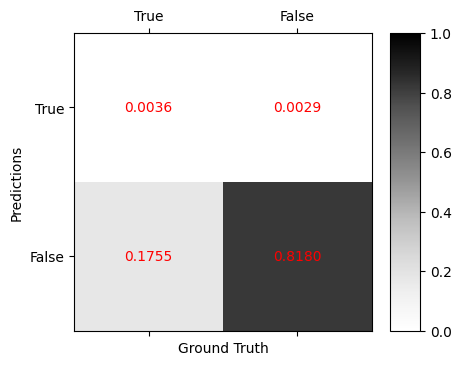

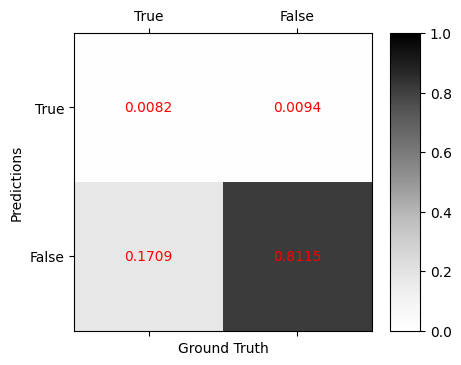

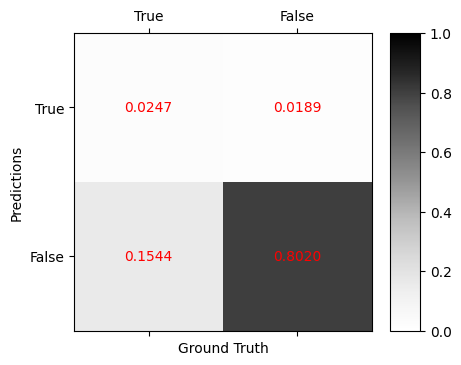

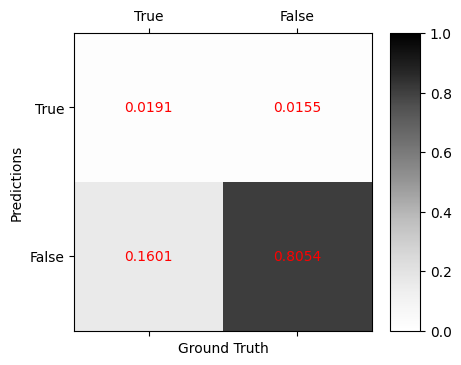

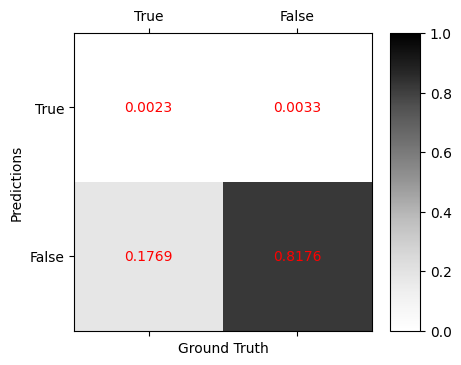

In [30]:
# 4. Training Model

model = UNet().to(DEVICE)

optimizer = optim.Adam(model.parameters(),
                       lr = LEARNING_RATE)

scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda epoch: GAMMA ** epoch)

criterion = nn.BCEWithLogitsLoss().to(DEVICE)


if P4:
    model.to(DEVICE)
    loss_list = []
    f1_scores =[]
    fpr, tpr = [], []
    
    for i in tqdm(range(EPOCH), leave = False, desc = 'Epochs'):
        
        model.train()
        with tqdm(total = len(train_loader), leave = True, desc = '    Training') as bar:
            for image, mask in train_loader:
                optimizer.zero_grad()
                
                x = image.to(DEVICE)
                y = mask.to(DEVICE)
                pred = model(x)
                loss = criterion(pred, y)
                
                loss.backward()
                optimizer.step()
                bar.update(1)
        
        model.eval()
        tp, fp, tn, fn = (0,) * 4
        loss = 0
        with torch.no_grad():
            with tqdm(total = len(valid_loader), leave = True, desc = '    Validation') as bar:
                for image, mask in valid_loader:
                    x = image.to(DEVICE)
                    y = mask.to(DEVICE)
                    
                    pred = model(x)
                    loss += criterion(pred, y) * x.shape[0]
                    confusion_values = calc_conf_metrics_value(torch.sigmoid(pred), y)

                    tp += confusion_values["tp"]
                    fp += confusion_values["fp"]
                    tn += confusion_values["tn"]
                    fn += confusion_values["fn"]
                    bar.update(1)
        
        loss_list.append(loss / len(valid_images))
        f1_scores.append(get_F1(tp, fp, fn))
        x, y = get_ROC_point(tp, fp, tn, fn)
        
        print(f"tp>:{tp}, fp<:{fp}, tn>:{tn}, fn<:{fn}")
        print("loss:", loss_list[-1])
        print(f"f1 score: {f1_scores[-1]:.6f}")
        print(f"fpr, tpr: {x:.6f}, {y:.6f}")
        
        fpr.append(x)
        tpr.append(y)
        
        torch.save(model, f'./models/model_{i}epoch.pth')
        save_conf_metrics([[tp, fp], [fn, tn]],
                          IMAGE_SIZE[0] * IMAGE_SIZE[1] * len(valid_images),
                          f"epoch-{i}.png")
        
        scheduler.step()
    
    print("Done.")
    

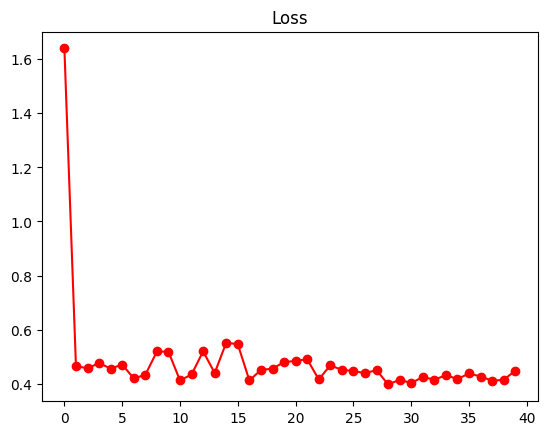

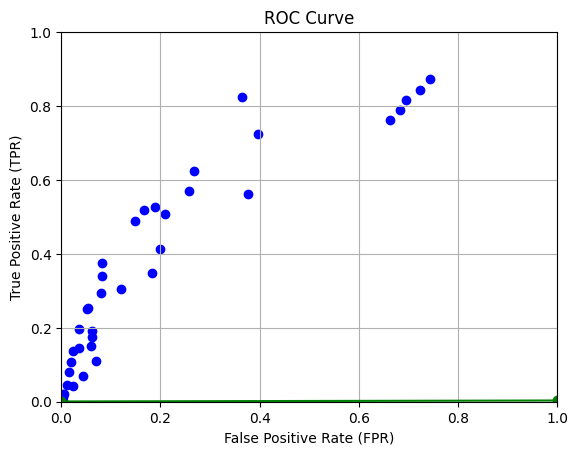

In [34]:
# Save Loss Plot
save_line_graph(range(len(loss_list)), loss_list, color='r',
               title="Loss", file_name="Loss Graph.png")

# Save F1 Score Plot
save_line_graph(range(len(f1_scores)), f1_scores, color='g',
                title="F1 Score", file_name="F1 Score.png", ylim=[0., 1.])

# Save ROC Curve
plt.scatter(fpr, tpr, color='b')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.savefig("ROC Curve.png")

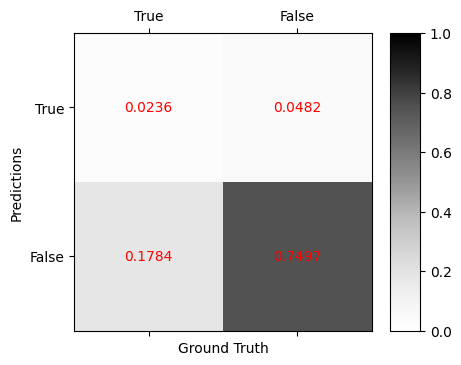

In [37]:
# 5. Test
if P5:
    model = UNet()
    # Best epoch: 20
    model.load_state_dict(torch.load("./models/model_20epoch.pth"))
    model.eval()
    
    test_set = TransparentDataset(
        img_path = test_images,
        mask_path = test_masks,
        transform = transform
    )
    
    test_loader = DataLoader(
        test_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
        num_workers = NUM_WORKERS,
        prefetch_factor = NUM_WORKERS
    )
    
    tp, fp, tn, fn = (0,) * 4
    f1_sscores = []
    with torch.no_grad():
        with tqdm(total = len(test_loader), leave = False, desc = '    Test') as bar:
            for image, mask in test_loader:
                x = image.to(DEVICE)
                y = mask.to(DEVICE)

                pred = model(x)
                confusion_values = calc_conf_metrics_value(torch.sigmoid(pred), y)

                tp += confusion_values["tp"]
                fp += confusion_values["fp"]
                tn += confusion_values["tn"]
                fn += confusion_values["fn"]

                bar.update(1)
    
    save_conf_metrics([[tp, fp], [fn, tn]],
                      IMAGE_SIZE[0] * IMAGE_SIZE[1] * len(test_images),
                      "test.png")

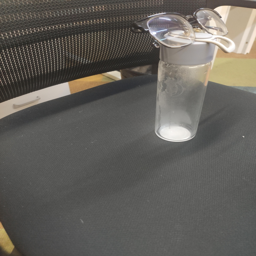

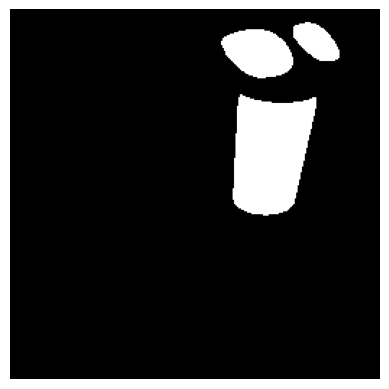

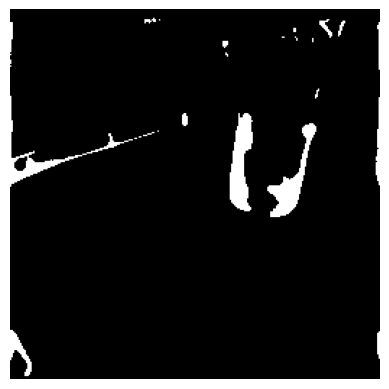

In [66]:
# Test one image and View
def view_test_case(images, masks, idx):
    img = Image.open(images[idx])
    width, height = img.size
    img = img.resize((256, 256))
    ground_truth = Image.open(masks[idx]).getchannel("R").resize((256, 256))
    ground_truth = to_tensor(ground_truth) / 255.0
    ground_truth = (ground_truth > 0).float().reshape((256, 256))

    img.show()
    plt.axis('off')
    plt.imshow(ground_truth.numpy(), cmap='gray')
    plt.show()
    
    img = transform(img).reshape(1, 3, 256, 256)
    prediction = (torch.sigmoid(model(img)) >= THRESHOLD).float()
    prediction = prediction.squeeze().detach().numpy()
    
    plt.axis('off')
    plt.imshow(prediction, cmap='gray')
    plt.show()

# View one image
idx = 5
view_test_case(test_images, test_masks, idx)